In [ ]:
#%pip install gensim

In [27]:
#%pip install spacy

In [36]:
#!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
#Imports
import pandas as pd
import pickle
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
import lda
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

import gensim
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim import matutils

import spacy


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [10]:
#Import soptify + genius dataset with song lyrics
df_lyrics = pd.read_pickle("df_rap_7k.pickle")

In [11]:
df_lyrics.head()

,track_id,album_id,artist_id,duration_ms,flg_explicit,url,track_name,track_popularity,track_type,track_danceability,...,track_release_year,track_release_decade,artist_name,artist_genres,artist_followers,artist_popularity,lyrics,lyrics_clean,lyrics_clean_split,lyrics_wordlen
0,3SUiKUnZlKYliid0ZlCmUY,0uYanB3WWNU2lT9AYxCstH,3M1quhETLChtt9NHKVaajX,189405,True,https://api.spotify.com/v1/tracks/3SUiKUnZlKYl...,Detroit Flow,44,track,0.793,...,2020,20,Quin Nfn,"[austin hip hop, southern hip hop, vapor trap]",257151,61,"Detroit Flow Lyrics\n(Ayy, DJ Showoutt, fuck g...",detroit flow fuck hold really like sound beats...,"[detroit, flow, fuck, hold, really, like, soun...",244
1,2jdWfnwHSZLuBFzsA6axWt,0iNKw3iqIEy2dh7RUdKzjY,0nQlnRkAhiWnSjTmB4JkfK,273099,True,https://api.spotify.com/v1/tracks/2jdWfnwHSZLu...,Handz in da Air,8,track,0.826,...,2018,10,Sons of Light,[],141,7,Pet Sound LyricsTurbid:\nYes it's Turbid and I...,pet sound yes turbid like reclaim freely like ...,"[pet, sound, yes, turbid, like, reclaim, freel...",209
2,2vcLUuRT3sqXnPJaIX5w5c,0VptfDjz26NkJS4b7bjmNK,0FtsMKmZEq8fBWqdSOWtqp,236619,True,https://api.spotify.com/v1/tracks/2vcLUuRT3sqX...,Substance (We Woke Up),20,track,0.731,...,2021,20,03 Greedo,"[cali rap, melodic rap, trap, vapor trap]",317202,71,"Substance (We Woke Up) Lyrics\nYeah, 03\nYeah,...",substance woke yeah yeah yeah yeah beat boy ta...,"[substance, woke, yeah, yeah, yeah, yeah, beat...",269
3,1r0faljjM2b876iNoaDUh5,0XAIjjN5qxViVS0Y5fYkar,0c173mlxpT3dSFRgMO8XPh,287320,True,https://api.spotify.com/v1/tracks/1r0faljjM2b8...,Sacrifices,56,track,0.779,...,2017,10,Big Sean,"[detroit hip hop, hip hop, pop, pop rap, rap, ...",9276030,84,"Sacrifices Lyrics\nBrrrt!\nI look up, so many ...",look many shit many young metro trust gon shoo...,"[look, many, shit, many, young, metro, trust, ...",421
4,3yhatBRYsMwuozCdQsGiTS,2t70lfxoIbKZHKFKN9ZnqE,0auu2itHTxEdAMRHvx7CyG,283200,False,https://api.spotify.com/v1/tracks/3yhatBRYsMwu...,Hard Core Rap Act,28,track,0.813,...,1995,90,Das EFX,"[east coast hip hop, gangster rap, hardcore hi...",301411,60,Hardcore Rap Act LyricsIntro/Hook (x2)\n(*The ...,hardcore rap act hook hardcore rap act back ha...,"[hardcore, rap, act, hook, hardcore, rap, act,...",267


In [12]:
#Create lemmatizer, stemmer and define stopwords

word_tokenizer=RegexpTokenizer(r'\w+')

wordnet_lemmatizer = WordNetLemmatizer()

stemmer = PorterStemmer()

stopwords_nltk = set(stopwords.words('english'))



In [13]:
#Save lyrics
temp = df_lyrics["lyrics_clean"].copy()

In [14]:
# Define tokenizer function for CountVectorizer
def tokenize_text(raw_text):
    text = raw_text.lower()
    tokens = word_tokenizer.tokenize(text)
    return tokens

In [15]:
# Define tokenizer + lemmatizer function for CountVectorizer
def tokenize_text_lemma(raw_text):
    lowercase = raw_text.lower()  
    tokens = word_tokenizer.tokenize(lowercase)
    lemmed_text = [wordnet_lemmatizer.lemmatize(i) for i in tokens]

    return lemmed_text

In [16]:
# Define tokenizer + stemmer function for CountVectorizer
def tokenize_text_stem(raw_text):
    lowercase = raw_text.lower()
    tokens = word_tokenizer.tokenize(lowercase)
    stemmed_text = [stemmer.stem(i) for i in tokens ]

    return stemmed_text

In [17]:
#Function to vectorize lyrics
def count_vectorize_lyrics(df, tokenizer):
    vectorizer = CountVectorizer(tokenizer = tokenizer, stop_words = stopwords_nltk, decode_error="ignore")
    total_words = vectorizer.fit_transform(df["lyrics_clean"])
    vocab = vectorizer.get_feature_names_out()
    return total_words, vectorizer, vocab

In [25]:
#Function to run LDA for lyrics
#Args are: dataframe with songs, vectorized lyrics, number of topics, vectorizer model, check_convergence, number of iterations
#Returns all topic scores and topic scores for artists
#If check_convergence == True then print convergence plot
#LDA run with 500 iterations hardcoded

def get_topics(df, lyrics, vectorizer, ntopics = 10, check_convergence = False, n_iter = 100 ):
    
    model = lda.LDA(n_topics=int(ntopics), n_iter=n_iter, random_state=1)
    model.fit(lyrics)
    
    #Word-Topic distributions
    topic_word = model.topic_word_
    
    #Document-Topic distributions
    doc_topic = model.doc_topic_
    doc_topic = pd.DataFrame(doc_topic)

    #Join topic distributions to song dataframe
    df = df.join(doc_topic)

    # Define dataframe to see topics by songs
    songs = pd.DataFrame(df)

    # Word-Topic dataframe
    topics = pd.DataFrame(topic_word)
    
    topics.columns = vectorizer.get_feature_names_out()
    
    topics_transpose = topics.transpose()

    if check_convergence:
        plt.plot(model.loglikelihoods_[:])
        
    return topics_transpose, songs

In [26]:
#Function to sort topic coeffs by importance 
#Args are: dataframe of topics
#Returns a dict with list of sorted coeffs as values
def get_sorted_coeffs(topics):
    topics_sorted_dict = {}

    for i in range(len(topics.columns)):
        topics_sorted_dict[i] = topics.iloc[:,i].sort_values(ascending=False)
    
    return topics_sorted_dict

In [27]:
#Count vectorize all songs
words_all_songs, count_vectorizer, vocab = count_vectorize_lyrics(df_lyrics, tokenize_text_lemma)

C:\Users\louis\anaconda3\envs\INSY669\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


INFO:lda:n_documents: 6783
INFO:lda:vocab_size: 23265
INFO:lda:n_words: 1739398
INFO:lda:n_topics: 8
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -17134675
INFO:lda:<10> log likelihood: -14661625
INFO:lda:<20> log likelihood: -14075913
INFO:lda:<30> log likelihood: -13915432
INFO:lda:<40> log likelihood: -13833010
INFO:lda:<50> log likelihood: -13782847
INFO:lda:<60> log likelihood: -13750455
INFO:lda:<70> log likelihood: -13720206
INFO:lda:<80> log likelihood: -13699920
INFO:lda:<90> log likelihood: -13677627
INFO:lda:<99> log likelihood: -13660884


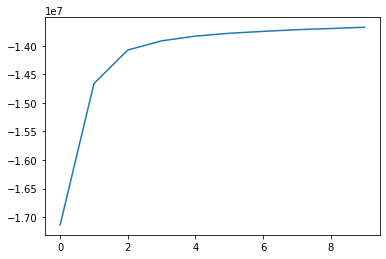

In [28]:
topics_all_songs, songs_all_songs = get_topics(df_lyrics, words_all_songs, 
                                                 vectorizer = count_vectorizer, ntopics=8, check_convergence=True)

In [29]:
topics_sorted_all_songs = get_sorted_coeffs(topics_all_songs)

In [34]:
#Export songs to pickle for Carlos
songs_all_songs.to_pickle("df_lyrics_topics.pickle")

In [35]:
songs_all_songs

,track_id,album_id,artist_id,duration_ms,flg_explicit,url,track_name,track_popularity,track_type,track_danceability,...,lyrics_clean_split,lyrics_wordlen,0,1,2,3,4,5,6,7
0,3SUiKUnZlKYliid0ZlCmUY,0uYanB3WWNU2lT9AYxCstH,3M1quhETLChtt9NHKVaajX,189405,True,https://api.spotify.com/v1/tracks/3SUiKUnZlKYl...,Detroit Flow,44,track,0.793,...,"[detroit, flow, fuck, hold, really, like, soun...",244,0.000408,0.102533,0.302696,0.000408,0.000408,0.000408,0.049428,0.543709
1,2jdWfnwHSZLuBFzsA6axWt,0iNKw3iqIEy2dh7RUdKzjY,0nQlnRkAhiWnSjTmB4JkfK,273099,True,https://api.spotify.com/v1/tracks/2jdWfnwHSZLu...,Handz in da Air,8,track,0.826,...,"[pet, sound, yes, turbid, like, reclaim, freel...",209,0.000477,0.124404,0.076740,0.195901,0.000477,0.262631,0.272164,0.067207
2,2vcLUuRT3sqXnPJaIX5w5c,0VptfDjz26NkJS4b7bjmNK,0FtsMKmZEq8fBWqdSOWtqp,236619,True,https://api.spotify.com/v1/tracks/2vcLUuRT3sqX...,Substance (We Woke Up),20,track,0.731,...,"[substance, woke, yeah, yeah, yeah, yeah, beat...",269,0.045015,0.000372,0.071057,0.000372,0.004092,0.435640,0.022693,0.420759
3,1r0faljjM2b876iNoaDUh5,0XAIjjN5qxViVS0Y5fYkar,0c173mlxpT3dSFRgMO8XPh,287320,True,https://api.spotify.com/v1/tracks/1r0faljjM2b8...,Sacrifices,56,track,0.779,...,"[look, many, shit, many, young, metro, trust, ...",421,0.012091,0.185159,0.230204,0.000237,0.156709,0.223092,0.000237,0.192271
4,3yhatBRYsMwuozCdQsGiTS,2t70lfxoIbKZHKFKN9ZnqE,0auu2itHTxEdAMRHvx7CyG,283200,False,https://api.spotify.com/v1/tracks/3yhatBRYsMwu...,Hard Core Rap Act,28,track,0.813,...,"[hardcore, rap, act, hook, hardcore, rap, act,...",267,0.015310,0.384989,0.030246,0.459671,0.000373,0.000373,0.000373,0.108663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6778,3YzxXVNHGZF09eGqhsYuHI,6CM5qhYBvpgYNek5kYwuOJ,20qISvAhX20dpIbOOzGK3q,187175,True,https://api.spotify.com/v1/tracks/3YzxXVNHGZF0...,The Pressure,56,track,0.573,...,"[pressure, pressure, pressure, feel, pressure,...",192,0.000519,0.462137,0.166494,0.130187,0.000519,0.000519,0.239108,0.000519
6779,7KIbDUwumrpG5f30kEYW1v,6Gdt5ogiuJ9knp8Q5148ea,1yxSLGMDHlW21z4YXirZDS,213066,False,https://api.spotify.com/v1/tracks/7KIbDUwumrpG...,Pump It,0,track,0.648,...,"[pump, pump, pump, pump, pump, pump, turn, rad...",179,0.000559,0.000559,0.056488,0.615772,0.000559,0.257830,0.000559,0.067673
6780,4a4dFaA4NfXU5A3snq2ZMa,4MloRVOQvX5YAfu2ik7OA9,3BeQqzKdlARoOd6y30kCO2,263773,True,https://api.spotify.com/v1/tracks/4a4dFaA4NfXU...,Made Man,12,track,0.647,...,"[made, man, singing, background, blessing, liv...",184,0.000541,0.498377,0.233225,0.179113,0.000541,0.022186,0.065476,0.000541
6781,2HIjQZsmscClqRGbfzwAgK,24jAbLMFzCTlIv3kQ94HwK,50co4Is1HCEo8bhOyUWKpn,210733,True,https://api.spotify.com/v1/tracks/2HIjQZsmscCl...,Diamonds (feat. Gunna),55,track,0.919,...,"[highest, lowest, young, stoner, life, stoner,...",256,0.981698,0.000389,0.000389,0.004283,0.000389,0.000389,0.000389,0.012072


<AxesSubplot:>

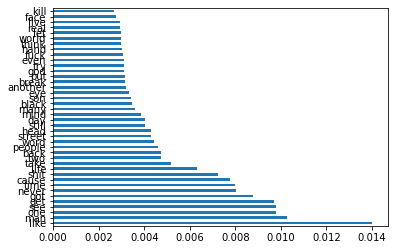

In [15]:
topics_sorted_all_songs[1].head(40).plot(kind="barh")

In [22]:
topics_sorted_all_songs[0].head(10)

feat      0.168121
young     0.018441
baby      0.012726
thug      0.011604
big       0.009472
kid       0.009279
scott     0.008524
travis    0.008292
drake     0.007978
future    0.007659
Name: 0, dtype: float64

In [17]:
artists_all_songs

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
artist_name,,,,,,,,
$NOT,0.172803,0.088220,0.073071,0.004418,0.128310,0.142930,0.110078,0.280170
$uicideboy$,0.011507,0.340344,0.104625,0.047269,0.129579,0.062095,0.086840,0.217741
03 Greedo,0.022769,0.073823,0.135371,0.000448,0.010170,0.220703,0.310351,0.226365
070 Shake,0.000731,0.022249,0.044107,0.000731,0.229061,0.617681,0.008618,0.076820
1takejay,0.002545,0.084188,0.446376,0.015551,0.035906,0.000460,0.018066,0.396909
...,...,...,...,...,...,...,...,...
mansionz,0.000757,0.226234,0.311172,0.000757,0.000757,0.335677,0.014015,0.110630
mike.,0.001020,0.061255,0.244835,0.002820,0.118689,0.359896,0.020465,0.191020
slowthai,0.125743,0.221059,0.066117,0.051791,0.055632,0.164637,0.193351,0.121670


# Topics by 5-year segments

In [ ]:
#Function to get a dict containing epoch end and start year
#Args: dataframe with songs, number of years in epoch
#Returns: dict with lists [start year, end_year] as values

#TO IMPROVE: make it so last epoch is as short as it can be instead of full 5
def get_epochs(df, num_years):
    min_year = df.track_release_year.min()
    max_year = df.track_release_year.max()

    i = 0
    dict_epoch = {}
    counter = max_year
    temp_min = min_year

    while counter >= min_year:
        temp_list = []

        dict_epoch[i] = temp_list

        i += 1

        temp_list.insert(1, counter)
        counter -= num_years
        temp_list.insert(0, counter + 1)

        continue

    num_epochs = i
    
    print(f"Oldest release was in {min_year}. Newest release was in {max_year}")
    
    print(f"There are {num_epochs} epochs of 5 years.")
    
    return dict_epoch

In [ ]:
dict_epoch_all_songs = get_epochs(df_lyrics, 5)

In [ ]:
dict_epoch_all_songs

In [ ]:
#df_filtered = df_lyrics[df_lyrics.track_release_decade.isin(["90","00","10","20"])]

#pd.cut(df_filtered.track_release_year, bins = 6)

In [ ]:
# Get topics by epoch

topic_dict_list = []
artists_df_list = []

for i in range(len(dict_epoch_all_songs)):
    
    #Only get songs for that epoch
    df_temp = df_lyrics[(df_lyrics.track_release_year >= dict_epoch_all_songs[i][0])
                        & (df_lyrics.track_release_year <= dict_epoch_all_songs[i][1])]
    
    #Check to see how many songs are in df
    print(f"There are {len(df_temp)} songs in epoch {i}: {dict_epoch_all_songs[i][0]} to {dict_epoch_all_songs[i][1]}")
    
    #Break loop if df is empty
    if df_temp.empty:
        print('Break: no songs')
        break
        
    #Vectorize lyrics
    vec_lyrics, count_vectorizer = count_vectorize_lyrics(df_temp, tokenize_text_lemma)
    
    #Get topics and artists df
    temp_topics, temp_artists = get_topics(df_temp, vec_lyrics, vectorizer = count_vectorizer, check_convergence=True)
    
    #Sort topic coeffs
    temp_topics_sorted = get_sorted_coeffs(temp_topics)
    
    topic_dict_list.append(temp_topics_sorted)
    artists_df_list.append(temp_artists)

In [ ]:
topic_dict_list[0]

In [ ]:
topic_dict_list[1][0]

In [ ]:
artists_df_list[0]

In [ ]:
artists_df_list[1]

In [ ]:
artists_df_list[2]

# Topics for Artist: Nas

In [ ]:
df_nas = df_lyrics[df_lyrics.artist_name == 'Nas']

In [ ]:
#Vectorize lyrics
words_nas, count_vectorizer = count_vectorize_lyrics(df_nas, tokenize_text_lemma)

In [ ]:
#Create topics with LDA
topics_nas, artists_nas = get_topics(df_nas, words_nas, 
                                                 vectorizer = count_vectorizer, ntopics=10, check_convergence=True)

In [ ]:
#Sort the topics
topics_sorted_nas = get_sorted_coeffs(topics_nas)

In [ ]:
topics_sorted_nas

## Topics by Period

In [ ]:
dict_epoch_nas = get_epochs(df_nas, 5)

In [ ]:
# Get topics by epoch

topic_nas_list = []
artists_irrelevant = []

for i in range(len(dict_epoch_nas)):
    
    #Only get songs for that epoch
    df_temp = df_nas[(df_nas.track_release_year >= dict_epoch_nas[i][0])
                        & (df_nas.track_release_year <= dict_epoch_nas[i][1])]
    
    #Check to see how many songs are in df
    print(f"There are {len(df_temp)} songs in epoch {i}: {dict_epoch_nas[i][0]} to {dict_epoch_nas[i][1]}")
    
    #Break loop if df is empty
    if df_temp.empty:
        print('Break: no songs')
        break
        
    #Vectorize lyrics
    vec_lyrics, count_vectorizer = count_vectorize_lyrics(df_temp, tokenize_text_lemma)
    
    #Get topics and artists df
    temp_topics, temp_artists = get_topics(df_temp, vec_lyrics, vectorizer = count_vectorizer, check_convergence=True)
    
    #Sort topic coeffs
    temp_topics_sorted = get_sorted_coeffs(temp_topics)
    
    topic_nas_list.append(temp_topics_sorted)
    artists_irrelevant.append(temp_artists)

In [ ]:
dict_epoch_nas

In [ ]:
topic_nas_list[0][0].head(40).plot.bar()

In [ ]:
topic_nas_list[0][1].head(40).plot.bar()

In [ ]:
topic_nas_list[0][2].head(40).plot.bar()

In [ ]:
topic_nas_list[0][3].head(40).plot.bar()

In [ ]:
topic_nas_list[0][4].head(40).plot.bar()